<a href="https://colab.research.google.com/github/OmdenaAI/IECO/blob/seife/LAM3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
%cd '/content/drive/MyDrive/Colab Notebooks/IECO/'

/content/drive/MyDrive/Colab Notebooks/IECO


For 3D roof reconstruction, we need to prepare a dataset that can handle both aerial images and their corresponding 3D representations (e.g., point clouds or DSMs). Below is an implementation for a custom PyTorch Dataset class that loads and preprocesses this data.

**Step 1: Implementing the PyTorch Dataset Class**

Outline of the Custom Dataset Class

1. Dataset Structure: Each data sample should contain:
- An aerial image.
- A corresponding point cloud or digital surface model (DSM) for 3D information.

2. Dataset Initialization:
- Store paths to the images and DSM files.
- Apply any transformations for preprocessing images and DSMs.

3. Load and Transform Data:
- Load aerial images and convert them into PyTorch tensors.
- Load the DSM or point cloud data, which is also converted into a tensor format suitable for the model.
- Apply any augmentations if required.

In [4]:
import os
import json
import torch
import numpy as np
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class RoofDataset(Dataset):
    def __init__(self, base_path, transform=None, dsm_transform=None, fixed_dsm_shape=(9807, 3), perimeter_size=5, max_planes=4):
        """
        Args:
            base_path (str): Base directory containing subdirectories of paired images, DSM, and SDF files.
            transform (callable, optional): Optional transform to be applied on the images.
            dsm_transform (callable, optional): Optional transform to be applied on the DSM or point cloud data.
            fixed_dsm_shape (tuple): Target shape for DSM tensors (points, dimensions).
            perimeter_size (int): Fixed number of perimeter points to pad or truncate to.
            max_planes (int): Maximum number of planes (rows) in the target SDF tensor.
        """
        self.image_paths = []
        self.point_cloud_paths = []
        self.target_sdf_paths = []
        self.transform = transform
        self.dsm_transform = dsm_transform
        self.fixed_dsm_shape = fixed_dsm_shape  # Target shape for DSM tensors
        self.perimeter_size = perimeter_size    # Target length for perimeter points
        self.max_planes = max_planes            # Maximum number of planes in target SDF

        # Populate image, point cloud, and target SDF paths
        for image_dir in os.listdir(base_path):
            image_path = os.path.join(base_path, image_dir)
            if os.path.isdir(image_path):
                img_path = os.path.join(image_path, 'google.jpg')
                point_cloud_path = os.path.join(image_path, 'dsm.json')
                target_sdf_path = os.path.join(image_path, 'planes.json')

                # Check if all files exist
                if os.path.isfile(img_path) and os.path.isfile(point_cloud_path) and os.path.isfile(target_sdf_path):
                    self.image_paths.append(img_path)
                    self.point_cloud_paths.append(point_cloud_path)
                    self.target_sdf_paths.append(target_sdf_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load aerial image
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")

        # Apply transformations to the image, if any
        if self.transform:
            image = self.transform(image)

        # Load DSM or point cloud data
        dsm_path = self.point_cloud_paths[idx]
        with open(dsm_path, 'r') as f:
            dsm_data = np.array(json.load(f))  # Load DSM as numpy array

        # Pad or truncate DSM data to the fixed shape
        dsm_tensor = torch.zeros(self.fixed_dsm_shape, dtype=torch.float32)  # Start with a tensor of zeros
        num_points = min(dsm_data.shape[0], self.fixed_dsm_shape[0])         # Determine the number of points to copy
        dsm_tensor[:num_points, :] = torch.tensor(dsm_data[:num_points, :], dtype=torch.float32)  # Copy data

        # Apply transformations to the DSM data, if any
        if self.dsm_transform:
            dsm_tensor = self.dsm_transform(dsm_tensor)

        # Load target SDF data (planes.json)
        target_sdf_path = self.target_sdf_paths[idx]
        with open(target_sdf_path, 'r') as f:
            sdf_data = json.load(f)

        # Extract relevant fields and pad/truncate planes to `max_planes`
        target_sdf = []
        for plane in sdf_data[:self.max_planes]:  # Truncate if necessary
            perimeter_points = [
                coord for point in plane["perimeter"][:self.perimeter_size]  # Truncate perimeter if necessary
                for coord in (point["x"], point["y"])
            ]
            # Pad the perimeter points if fewer than required
            if len(perimeter_points) < self.perimeter_size * 2:
                perimeter_points.extend([0.0] * (self.perimeter_size * 2 - len(perimeter_points)))

            target_sdf.append([
                plane["azimuth"],
                plane["height"],
                plane["tilt"],
                *perimeter_points
            ])

        # Pad with zero planes if there are fewer than `max_planes`
        while len(target_sdf) < self.max_planes:
            target_sdf.append([0.0] * (3 + self.perimeter_size * 2))

        target_sdf_tensor = torch.tensor(target_sdf, dtype=torch.float32)

        # Return image, DSM, and target SDF tensors
        return {'image': image, 'dsm': dsm_tensor, 'target_sdf': target_sdf_tensor}

# Example transforms for images
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a fixed size
    transforms.ToTensor(),          # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initialize the dataset with the base path
base_path = '/content/drive/MyDrive/Colab Notebooks/OmdenaIECO/Valid_Projects_Batch_1'
roof_dataset = RoofDataset(base_path=base_path, transform=image_transform)

# Check dataset content
sample = roof_dataset[0]  # Retrieve first sample
print("Image shape:", sample['image'].shape)  # Expected: [3, 224, 224]
print("DSM shape:", sample['dsm'].shape)      # Expected: [9807, 3]
print("Target SDF shape:", sample['target_sdf'].shape)  # Shape depends on number of planes and points in perimeter


Image shape: torch.Size([3, 224, 224])
DSM shape: torch.Size([9807, 3])
Target SDF shape: torch.Size([4, 13])


Let's take a look at the first aerial image example

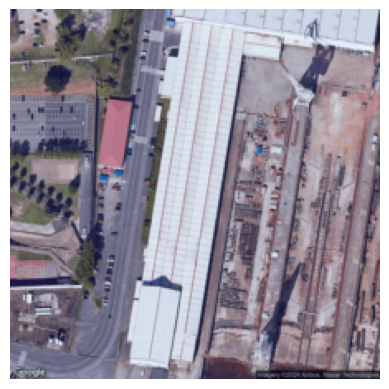

In [5]:
import numpy as np
import matplotlib.pyplot as plt

example = roof_dataset[80]
img_tensor_data = example['image']

# Convert to numpy array and transpose for visualization
image = img_tensor_data.numpy().transpose(1, 2, 0)

# Normalize values to 0-1 range for displaying
image = (image - image.min()) / (image.max() - image.min())

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()

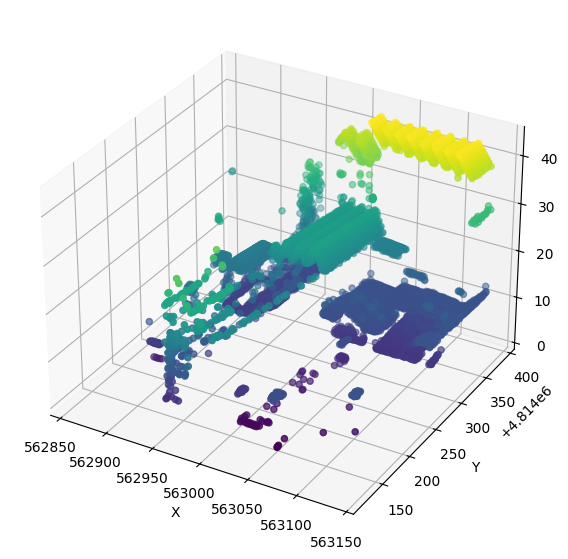

In [6]:
pcd_tensor_data = example['dsm']

# Convert tensor to numpy array for easier manipulation
point_cloud_np = pcd_tensor_data.numpy()

# Extract x, y, and z coordinates
x = point_cloud_np[:, 0]
y = point_cloud_np[:, 1]
z = point_cloud_np[:, 2]

# Plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=z, cmap='viridis', marker='o')

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

**Step 2: Creating PyTorch DataLoaders**
The DataLoader will allow us to efficiently feed mini-batches of data to the model during training and evaluation. Here’s the outline for creating DataLoaders:
1. **Define Training and Validation Splits**:
Split the dataset into training and validation sets to evaluate model performance during training.
2. **Initialize DataLoaders**:
Use PyTorch’s DataLoader class to create DataLoaders for each split.
Specify parameters like batch_size, shuffle, and num_workers to control data loading behavior.


In [7]:
from torch.utils.data import DataLoader, random_split

# Define dataset split ratios (e.g., 80% for training, 20% for validation)
train_ratio = 0.8
val_ratio = 0.2

# Calculate the number of samples for training and validation
total_samples = len(roof_dataset)
train_size = int(train_ratio * total_samples)
val_size = total_samples - train_size

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(roof_dataset, [train_size, val_size])

# Define batch size and other DataLoader parameters
batch_size = 8  # You can adjust this based on memory constraints

# Initialize DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Check DataLoader batches
for batch in train_loader:
    print("Batch image shape:", batch['image'].shape)      # Expected: [batch_size, 3, 224, 224]
    print("Batch DSM shape:", batch['dsm'].shape)          # Expected: [batch_size, 9807, 3]
    print("Batch target SDF shape:", batch['target_sdf'].shape)  # Expected: [batch_size, max_planes, perimeter_size * 2 + 3]
    break  # Only check the first batch for confirmation


Batch image shape: torch.Size([8, 3, 224, 224])
Batch DSM shape: torch.Size([8, 9807, 3])
Batch target SDF shape: torch.Size([8, 4, 13])


**Step 3: Defining the Model.**

**Model Architecture Summary**
- `Image Feature Extractor`: Uses the DINOv2 model to process aerial images.
- `PointCloudTransformer`: Processes the point cloud to obtain latent representations.
- `Diffusion Model`: Combines image and point cloud features over time steps to align them.
- `TriPlaneDecoder`: Decodes the aligned features to obtain 3D representation values, like SDF

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from transformers import AutoFeatureExtractor, Dinov2Model as DINOModel

# Ensure device is set to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the Image Feature Extractor
class ImageFeatureExtractor(nn.Module):
    def __init__(self):
        super(ImageFeatureExtractor, self).__init__()
        self.feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/dino-vitb16")
        self.model = DINOModel.from_pretrained("facebook/dino-vitb16").to(device)

    def forward(self, images):
        with torch.no_grad():  # No gradients needed for pre-trained model
            features = self.model(images).last_hidden_state  # Shape: [batch_size, num_tokens, feature_dim]
        return features

# Define the Point Cloud Transformer
class PointCloudTransformer(nn.Module):
    def __init__(self, input_dim=3, latent_dim=256):
        super(PointCloudTransformer, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, latent_dim)
        self.relu = nn.ReLU()

    def forward(self, point_cloud):
        B, N, _ = point_cloud.shape
        point_cloud_flat = point_cloud.view(B * N, -1)
        x = self.relu(self.fc1(point_cloud_flat))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        tri_planes = x.view(B, N, -1)
        return tri_planes

# Define the Diffusion Model for alignment
class DiffusionModel(nn.Module):
    def __init__(self, latent_dim=256, timesteps=1000, img_feature_dim=768):
        super(DiffusionModel, self).__init__()
        self.timesteps = timesteps
        self.fc1 = nn.Linear(latent_dim + img_feature_dim, 128)
        self.fc2 = nn.Linear(128, latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x, img_features, t):
        img_features = img_features.repeat_interleave(x.shape[1] // img_features.shape[1], dim=1)
        diff = x.shape[1] - img_features.shape[1]
        if diff > 0:
            padding = torch.zeros(img_features.shape[0], diff, img_features.shape[2], device=img_features.device)
            img_features = torch.cat([img_features, padding], dim=1)
        elif diff < 0:
            img_features = img_features[:, :x.shape[1], :]

        x = torch.cat([x, img_features], dim=-1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define the Tri-Plane Decoder
class TriPlaneDecoder(nn.Module):
    def __init__(self, latent_dim=256, output_dim=13):
        super(TriPlaneDecoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_dim)
        self.relu = nn.ReLU()

    def forward(self, tri_plane_summary):
        x = self.relu(self.fc1(tri_plane_summary))
        x = self.relu(self.fc2(x))
        sdf_values = self.fc3(x)  # Output shape: [batch_size, max_planes, 13]
        return sdf_values

# Define the Full Model combining all components
class Roof3DReconstructionModel(nn.Module):
    def __init__(self, latent_dim=256, img_feature_dim=768, max_planes=4):
        super(Roof3DReconstructionModel, self).__init__()

        # Image Feature Extractor
        self.image_feature_extractor = ImageFeatureExtractor()

        # Point Cloud Transformer
        self.point_cloud_transformer = PointCloudTransformer(input_dim=3, latent_dim=latent_dim)

        # Diffusion Model for alignment
        self.diffusion_model = DiffusionModel(latent_dim=latent_dim, img_feature_dim=img_feature_dim)

        # Tri-Plane Decoder for 3D reconstruction
        self.tri_plane_decoder = TriPlaneDecoder(latent_dim=latent_dim, output_dim=13)

        # Define pooling to match max_planes
        # self.pool = nn.AdaptiveAvgPool1d(max_planes)
        self.pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, images, point_clouds):
        # Step 1: Extract image features
        img_features = self.image_feature_extractor(images)

        # Step 2: Process point clouds to get latent tri-plane representations
        latent_tri_planes = self.point_cloud_transformer(point_clouds)

        # Step 3: Align image and point cloud features using the diffusion model
        aligned_features = self.diffusion_model(latent_tri_planes, img_features, t=1000)

        # Step 4: Pool the aligned features to match max_planes
        # aligned_features_pooled = self.pool(aligned_features.permute(0, 2, 1)).permute(0, 2, 1)  # Shape: [batch_size, max_planes, latent_dim]
        aligned_features_pooled = self.pool(aligned_features.permute(0, 2, 1)).permute(0, 2, 1)[:, 0, :]

        # Repeat the pooled features to create 4 planes
        aligned_features_pooled = aligned_features_pooled.unsqueeze(1).repeat(1, 4, 1)  # Shape: [batch_size, 4, latent_dim]


        # Step 5: Decode aligned features to get SDF values (3D representation)
        sdf_values = self.tri_plane_decoder(aligned_features_pooled)

        return sdf_values  # Shape: [batch_size, max_planes, 13]

# Instantiate the model and move to device
model = Roof3DReconstructionModel().to(device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
You are using a model of type vit to instantiate a model of type dinov2. This is not supported for all configurations of models and can yield errors.
Some weights of Dinov2Model were not initialized from the model checkpoin

**Testing the Model with a Forward Pass**

In [9]:
# Example forward pass with one batch
for batch in train_loader:
    images = batch['image'].to(device)
    point_clouds = batch['dsm'].to(device)

    # Forward pass
    sdf_values = model(images, point_clouds)
    print("SDF values shape:", sdf_values.shape)  # Expected shape depends on decoder output
    break  # Run only one batch for testing

SDF values shape: torch.Size([8, 4, 13])


**Step 4: Training the Model.**

In this step, we’ll define the `training loop`, `loss function`, `optimizer`, and `hyperparameters` for training. Here’s the outline:

- Loss Function:

We can use a loss function suitable for 3D reconstruction, such as `Mean Squared Error` (MSE) Loss, which compares the predicted SDF values against target SDF values.
- Optimizer:

We’ll use Adam, a commonly used optimizer for deep learning tasks, and set the learning rate based on typical values.
- Training Loop:

Each epoch will consist of a forward pass, calculating the loss, and backpropagating to update the model weights.
We’ll also add a validation step to monitor the model’s performance on the validation dataset.

In [10]:
import torch.optim as optim
import torch.nn as nn

# Define the loss function and optimizer
loss_fn = nn.MSELoss()  # MSE Loss for SDF prediction
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Hyperparameters
num_epochs = 10  # Set based on computational constraints
train_loss_history = []
val_loss_history = []

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_loss = 0.0

    # Training Phase
    for batch in train_loader:
        images = batch['image'].to(device)
        point_clouds = batch['dsm'].to(device)
        target_sdf = batch['target_sdf'].to(device)  # Actual target SDF values

        # Forward pass
        optimizer.zero_grad()  # Reset gradients
        sdf_pred = model(images, point_clouds)  # Predicted SDF values

        # Ensure predicted SDF and target SDF are compatible
        if sdf_pred.shape != target_sdf.shape:
            print(f"Shape mismatch: Predicted SDF {sdf_pred.shape}, Target SDF {target_sdf.shape}")
            continue  # Skip this batch if shapes do not match

        # Calculate loss
        loss = loss_fn(sdf_pred, target_sdf)
        train_loss += loss.item() * images.size(0)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader.dataset)
    train_loss_history.append(train_loss)

    # Validation Phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            images = batch['image'].to(device)
            point_clouds = batch['dsm'].to(device)
            target_sdf = batch['target_sdf'].to(device)

            # Forward pass
            sdf_pred = model(images, point_clouds)

            # Ensure predicted SDF and target SDF are compatible
            if sdf_pred.shape != target_sdf.shape:
                print(f"Shape mismatch: Predicted SDF {sdf_pred.shape}, Target SDF {target_sdf.shape}")
                continue

            # Calculate validation loss
            loss = loss_fn(sdf_pred, target_sdf)
            val_loss += loss.item() * images.size(0)

    val_loss /= len(val_loader.dataset)
    val_loss_history.append(val_loss)

    # Print epoch summary
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


Epoch [1/10], Train Loss: 984978.4283, Val Loss: 127038.1637
Epoch [2/10], Train Loss: 78259.9789, Val Loss: 43140.6483
Epoch [3/10], Train Loss: 18617.6244, Val Loss: 17546.1757
Epoch [4/10], Train Loss: 8597.4536, Val Loss: 6233.9748
Epoch [5/10], Train Loss: 4878.9018, Val Loss: 2159.5158
Epoch [6/10], Train Loss: 6888.4457, Val Loss: 3007.8407
Epoch [7/10], Train Loss: 3851.2366, Val Loss: 3343.4280
Epoch [8/10], Train Loss: 3019.1038, Val Loss: 2042.3036
Epoch [9/10], Train Loss: 2439.3478, Val Loss: 1975.9737
Epoch [10/10], Train Loss: 2266.0948, Val Loss: 1840.3735


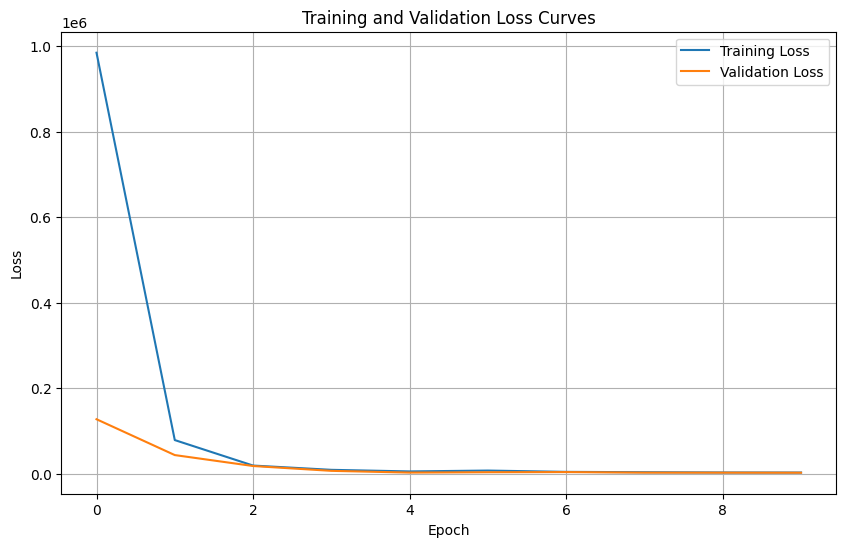

In [11]:
import matplotlib.pyplot as plt

# Plot training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()


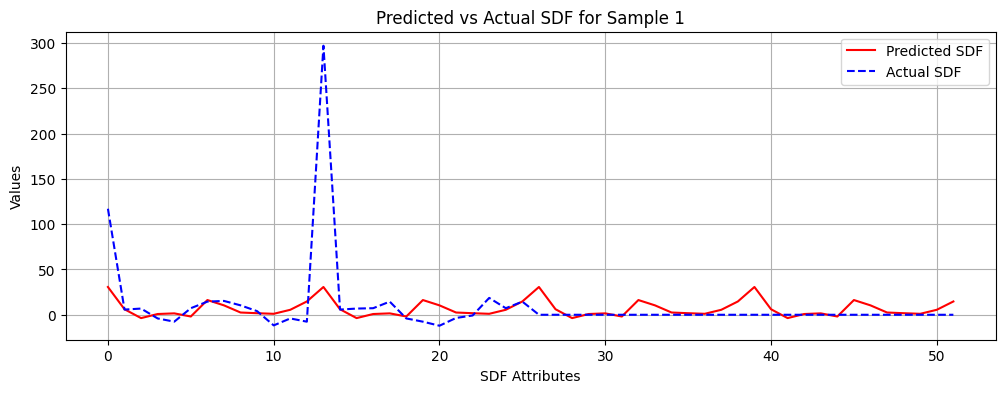

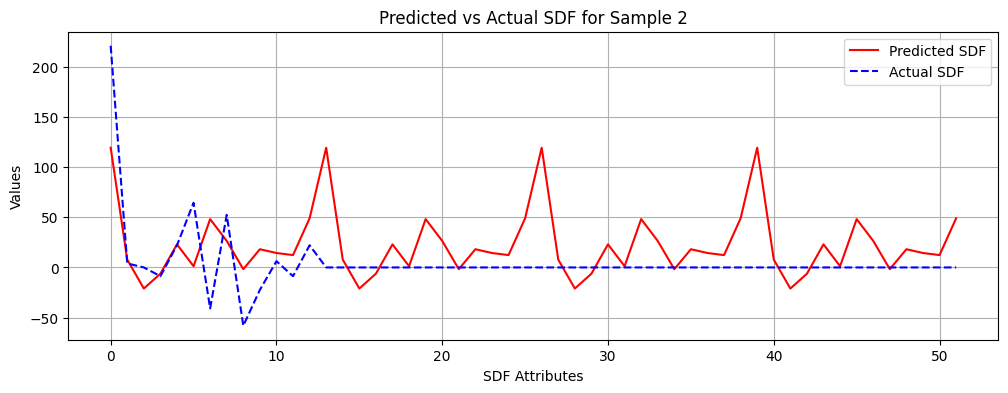

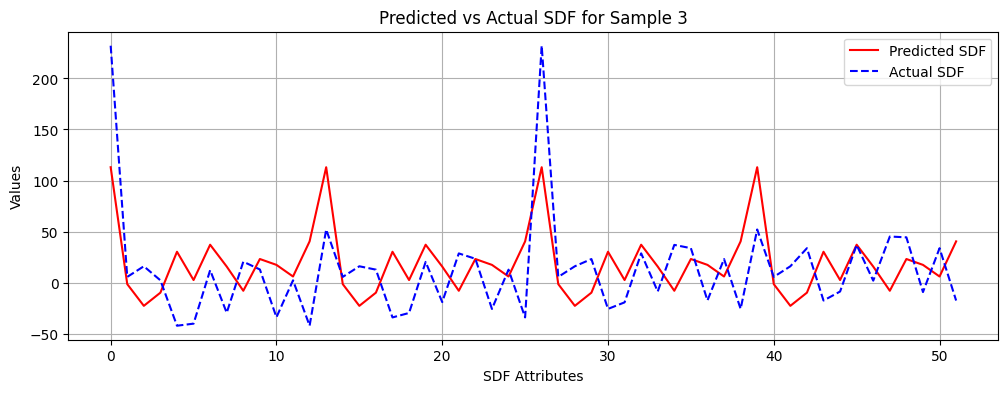

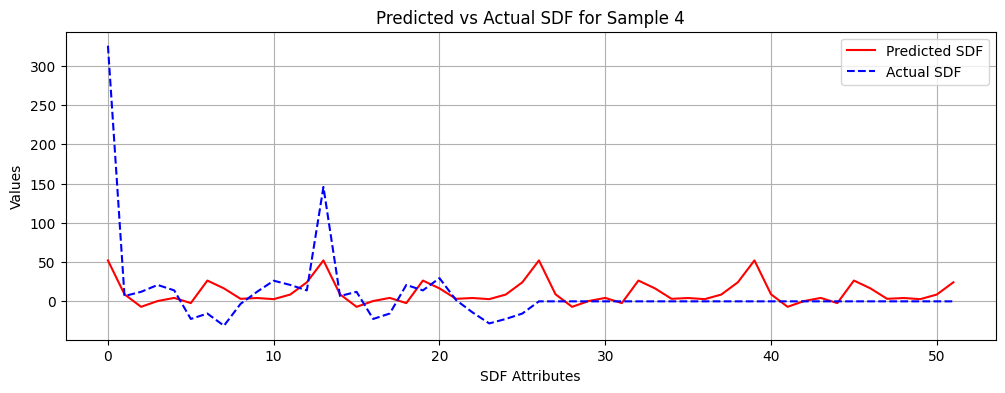

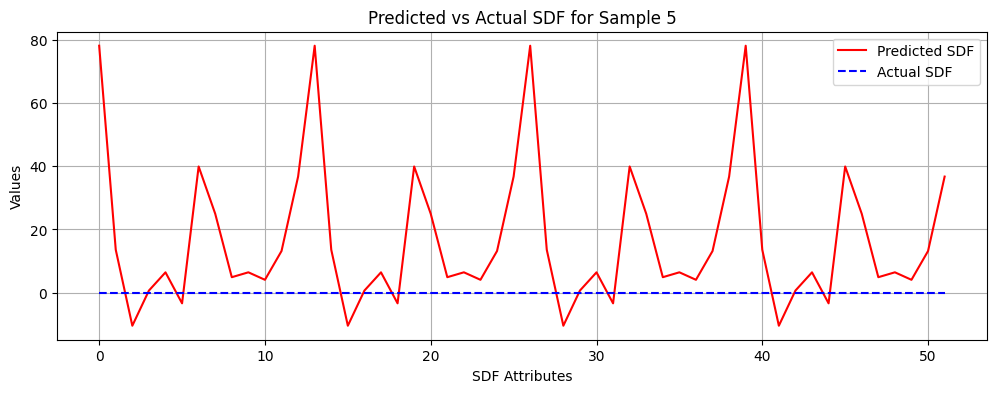

In [12]:
# Get a batch of validation data
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    batch = next(iter(val_loader))
    images = batch['image'].to(device)
    point_clouds = batch['dsm'].to(device)
    target_sdf = batch['target_sdf'].to(device)

    # Forward pass to get predictions
    sdf_pred = model(images, point_clouds)

# Convert predictions and targets to CPU for plotting
sdf_pred = sdf_pred.cpu().numpy()
target_sdf = target_sdf.cpu().numpy()

# Plot predicted vs. actual values for each attribute in SDF (e.g., azimuth, height, tilt, and perimeter points)
num_samples = min(5, len(sdf_pred))  # Limit number of samples to display
for i in range(num_samples):
    plt.figure(figsize=(12, 4))
    plt.plot(sdf_pred[i].flatten(), 'r-', label='Predicted SDF')
    plt.plot(target_sdf[i].flatten(), 'b--', label='Actual SDF')
    plt.xlabel('SDF Attributes')
    plt.ylabel('Values')
    plt.title(f'Predicted vs Actual SDF for Sample {i+1}')
    plt.legend()
    plt.grid(True)
    plt.show()


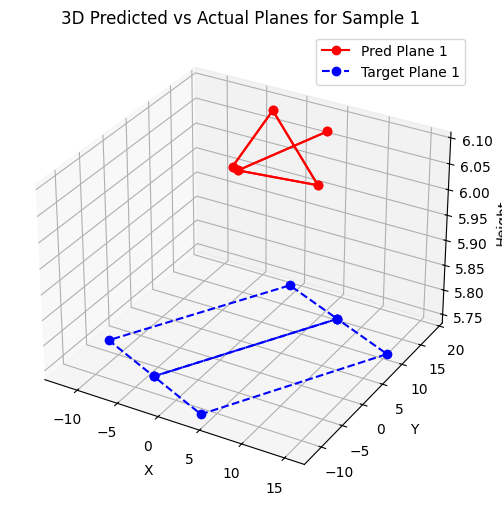

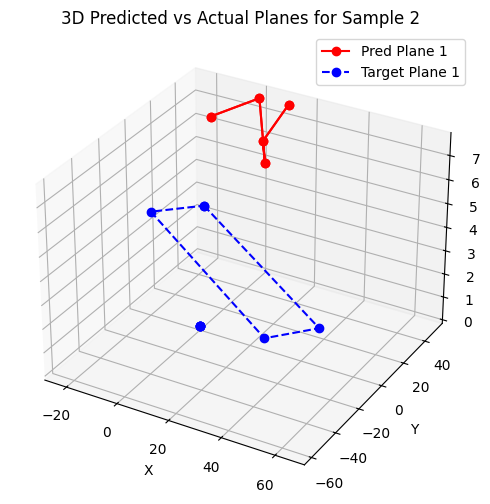

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_planes(sdf_pred, target_sdf, num_planes=2):
    """
    Plots predicted and actual planes in 3D for comparison.

    Args:
        sdf_pred (numpy.ndarray): Predicted SDF values, shape [batch_size, max_planes, 13].
        target_sdf (numpy.ndarray): Actual SDF values, shape [batch_size, max_planes, 13].
        num_planes (int): Number of planes to plot per sample.
    """
    num_samples = min(2, sdf_pred.shape[0])  # Limit to 1 sample for simplicity

    for sample_idx in range(num_samples):
        fig = plt.figure(figsize=(12, 6))
        ax = fig.add_subplot(111, projection='3d')

        for plane_idx in range(min(num_planes, sdf_pred.shape[1])):
            # Extract predicted and target values
            pred_plane = sdf_pred[sample_idx, plane_idx]
            target_plane = target_sdf[sample_idx, plane_idx]

            # Extract x, y perimeter coordinates and height
            pred_x = pred_plane[3:13:2]  # x-coordinates
            pred_y = pred_plane[4:13:2]  # y-coordinates
            pred_z = np.full_like(pred_x, pred_plane[1])  # height

            target_x = target_plane[3:13:2]
            target_y = target_plane[4:13:2]
            target_z = np.full_like(target_x, target_plane[1])

            # Plot predicted plane points
            ax.plot(pred_x, pred_y, pred_z, 'ro-', label=f'Pred Plane {plane_idx+1}' if plane_idx == 0 else "")

            # Plot actual plane points
            ax.plot(target_x, target_y, target_z, 'bo--', label=f'Target Plane {plane_idx+1}' if plane_idx == 0 else "")

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Height')
        ax.legend()
        ax.set_title(f'3D Predicted vs Actual Planes for Sample {sample_idx+1}')
        plt.show()

# Perform a forward pass on a batch to get predictions
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    batch = next(iter(val_loader))
    images = batch['image'].to(device)
    point_clouds = batch['dsm'].to(device)
    target_sdf = batch['target_sdf'].cpu().numpy()  # Move to CPU for plotting

    # Forward pass to get predictions
    sdf_pred = model(images, point_clouds).cpu().numpy()  # Predicted SDF values on CPU

# Plot 3D planes
plot_3d_planes(sdf_pred, target_sdf, num_planes=2)
